<a href="https://colab.research.google.com/github/heckelei/PromotionskollegModule6800_2020/blob/master/6800_Day1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 1 : Code used during lecture and lab assignment

### Instructions

- The notebook combines 'code used during lecture' with the 'Day 1 lab' assignment (see further down)
- The lab assignment can be done largely by copying/paste/modification of the code used during the lecture
- Please add answers/discussion/comments to the notebook as comments or text box. Do not create another file in addition.
- When you are done with your assignment, save the notebook in drive and add your last name to the name of the file
- Upload your final notebook to https://uni-bonn.sciebo.de/s/mTpqLLBN9Wu71Ku latest by September 30th. The password for access was sent to you by email

# Code used during lecture



In [1]:
# Import libaries that will be used in the notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
# Download data
!wget http://www.ilr.uni-bonn.de/agpo/courses/ml/brazil_all_data_v2.gz

--2021-02-27 22:53:38--  http://www.ilr.uni-bonn.de/agpo/courses/ml/brazil_all_data_v2.gz
Resolving www.ilr.uni-bonn.de (www.ilr.uni-bonn.de)... 131.220.69.2
Connecting to www.ilr.uni-bonn.de (www.ilr.uni-bonn.de)|131.220.69.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283350352 (270M) [application/x-gzip]
Saving to: ‘brazil_all_data_v2.gz’

brazil_all_data_v2. 100%[===================>] 270.22M  7.73MB/s    in 39s     

2021-02-27 22:54:19 (6.85 MB/s) - ‘brazil_all_data_v2.gz’ saved [283350352/283350352]



In [3]:
# Load data with pandas into a dataframe 
df = pd.read_parquet('brazil_all_data_v2.gz')

In [4]:
# Have a look at the data
print('Number of rows:', df.shape[0])
df.head(5)

Number of rows: 249940


,id,row,col,lon,lat,bean,carrot,cassava,chickpea,citrus,coffee,groundnut,maize,soy,sugarcane,tomato,wheat,perc_treecover,perm_water,travel_min,defor_2001,defor_2002,defor_2003,defor_2004,defor_2005,defor_2006,defor_2007,defor_2008,defor_2009,defor_2010,defor_2011,defor_2012,defor_2013,defor_2014,defor_2015,defor_2016,defor_2017,defor_2018,wdpa_1990,wdpa_1991,...,tot_defor_2016_lag_1st_order,tot_defor_2017_lag_1st_order,tot_defor_2018_lag_1st_order,tot_defor_2001_lag_2nd_order,tot_defor_2002_lag_2nd_order,tot_defor_2003_lag_2nd_order,tot_defor_2004_lag_2nd_order,tot_defor_2005_lag_2nd_order,tot_defor_2006_lag_2nd_order,tot_defor_2007_lag_2nd_order,tot_defor_2008_lag_2nd_order,tot_defor_2009_lag_2nd_order,tot_defor_2010_lag_2nd_order,tot_defor_2011_lag_2nd_order,tot_defor_2012_lag_2nd_order,tot_defor_2013_lag_2nd_order,tot_defor_2014_lag_2nd_order,tot_defor_2015_lag_2nd_order,tot_defor_2016_lag_2nd_order,tot_defor_2017_lag_2nd_order,tot_defor_2018_lag_2nd_order,tot_defor_2001_lag_3rd_order,tot_defor_2002_lag_3rd_order,tot_defor_2003_lag_3rd_order,tot_defor_2004_lag_3rd_order,tot_defor_2005_lag_3rd_order,tot_defor_2006_lag_3rd_order,tot_defor_2007_lag_3rd_order,tot_defor_2008_lag_3rd_order,tot_defor_2009_lag_3rd_order,tot_defor_2010_lag_3rd_order,tot_defor_2011_lag_3rd_order,tot_defor_2012_lag_3rd_order,tot_defor_2013_lag_3rd_order,tot_defor_2014_lag_3rd_order,tot_defor_2015_lag_3rd_order,tot_defor_2016_lag_3rd_order,tot_defor_2017_lag_3rd_order,tot_defor_2018_lag_3rd_order,s
0,0,0,0,-59.989876,-10.010125,200.00000,335.00000,201.0,0.0,391.0,237.00000,115.0,461.00000,209.00000,1295.0000,357.00000,0.0,99.761093,1.0,2612.6440,0.0,0.0,0.000000,0.009531,0.000000,0.000000,0.000000,0.002500,0.000000,0.000312,0.000000,0.000625,0.000312,0.000000,0.000000,0.000000,0.009531,0.000000,0.0,0.0,...,9.866667,6.600000,0.800000,0.000000,0.000000,10.625000,26.499998,17.500000,2.625000,2.125000,37.375000,1.125000,2.500000,2.500000,11.625000,0.625000,4.125000,4.875000,4.250000,9.875000,1.125000,0.000000,0.000000,5.800000,14.333333,9.800000,1.533333,1.333333,20.000000,0.800000,1.800000,1.333333,6.866667,0.733333,2.200000,4.466667,9.866667,6.600000,0.800000,1
1,1,0,1,-59.969875,-10.010125,200.00000,335.00000,201.0,0.0,391.0,237.00000,115.0,461.00000,209.00000,1295.0000,357.00000,0.0,99.777657,1.0,2680.3191,0.0,0.0,0.013125,0.008437,0.011875,0.003125,0.000781,0.046719,0.001094,0.002812,0.000000,0.002188,0.000625,0.002344,0.006094,0.000937,0.006562,0.001406,0.0,0.0,...,9.473684,6.210527,2.000000,0.000000,0.000000,0.272727,19.999998,5.818181,0.272727,1.363636,1.545454,0.363636,0.363636,1.818182,7.909091,0.818182,1.636364,1.272727,12.909090,10.181818,0.000000,0.000000,0.000000,0.157895,12.052631,3.842105,0.157895,0.894737,0.894737,1.000000,1.052631,2.000000,5.105263,0.526316,0.947368,1.473684,9.473684,6.210527,2.000000,1
2,2,0,2,-59.949875,-10.010125,200.00000,335.00000,201.0,0.0,391.0,237.00000,115.0,461.00000,209.00000,1295.0000,357.00000,0.0,99.766403,1.0,2796.3284,0.0,0.0,0.000000,0.024531,0.009375,0.000000,0.000156,0.000000,0.000000,0.000000,0.000312,0.000156,0.000000,0.000000,0.000000,0.001719,0.005313,0.000000,0.0,0.0,...,8.695652,11.217392,5.173913,0.000000,0.000000,6.214286,8.785713,5.857143,1.642857,1.500000,22.571428,1.785714,2.214286,2.571429,7.142858,1.000000,2.357143,3.785714,12.500000,8.571429,3.142857,0.086957,1.826087,6.869565,7.086957,8.260869,1.782609,4.347826,18.043478,1.956522,3.652174,1.652174,5.913043,4.086957,4.521739,4.956522,8.695652,11.217392,5.173913,1
3,3,0,3,-59.929874,-10.010125,200.00000,335.00000,201.0,0.0,391.0,237.00000,115.0,461.00000,209.00000,1295.0000,357.00000,0.0,99.814842,1.0,2920.0164,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000156,0.000000,0.000000,0.000000,0.000469,0.000000,0.000000,0.002188,0.017812,0.000469,0.000000,0.0,0.0,...,5.888889,19.629629,6.518518,0.142857,2.928571,11.285714,18.214285,17.214285,2.928571,6.142857,28.428572,3.142857,5.357143,2.785714,8.428572,5.857142,7.214285,6.142857,6.78

In [5]:
# Define target (dependent) variable (% forest cover for 2018)
strY = 'perc_treecover'


# Define a list of features names (explantory variables)
lstX = [
  'wdpa_2017',
  'population_2015',
  'chirps_2017',
  'maize',
  'soy',
  'sugarcane',
  'perm_water',
  'travel_min',
  'cropland',
  'mean_elev',
  'sd_elev',
  'near_road',
 ]



Run OLS on forest cover

In [6]:
# Get target variable and features
Y_all = df[strY]
X_all = df.loc[:,lstX]


In [7]:
# Run OLS using sklearn
# We run an regression using sklearn which is one of the most popular 
# libaries for machine learning 
 
# Define model (automatically add a constant and normalize the data) 
regOls = LinearRegression(fit_intercept=True, normalize=True)
# Fit model
regOls.fit(X_all, Y_all)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [8]:
from scipy.stats import norm
# View regression results
# Note: Sklearn is not econometric package and does not provide our classical 
# regression table output. This is not what the machine learning community
# looks at. However, we can calculate these things manually.

# Get coef
coefs = np.hstack((regOls.intercept_,regOls.coef_))

N = Y_all.shape[0]
K = coefs.shape[0]

# Get predicted values y hat
Y_hat = regOls.predict(X_all)
# Get errors
err = Y_all-Y_hat
# Get standard error of regression
sig2 = (err.transpose() @ err) / (N-K)
sig2

# Add constant to X_all (sklearn did this automatically)
Xc_all = np.insert(np.array(X_all), 0, 1, axis = 1)

# Covariance matrix for coef
VarBeta = sig2 * np.linalg.inv(Xc_all.T @ Xc_all)
# Standard error of coef
se = np.sqrt(np.diag(VarBeta))
# t-values
t =  coefs/se
# p-values  
p = (1 - norm.cdf(abs(t))) * 2
# Prepare df as output
resOls = pd.DataFrame(coefs,index=['const']+lstX,columns=['beta'])
resOls['SE'] = se
resOls['t'] = t
resOls['p-value'] = p
resOls

,beta,SE,t,p-value
const,-5.831235,1.324112,-4.403882,0.000011
wdpa_2017,11.427969,0.156940,72.817276,0.000000
population_2015,-0.008522,0.000677,-12.595832,0.000000
chirps_2017,0.036649,0.000314,116.867636,0.000000
maize,0.019095,0.000159,120.445045,0.000000
soy,-0.030865,0.000407,-75.758273,0.000000
sugarcane,-0.003199,0.000141,-22.739455,0.000000
perm_water,-21.908606,1.184469,-18.496556,0.000000
travel_min,0.019945,0.000139,143.456389,0.000000
cropland,-1.174515,0.540421,-2.173335,0.029755


In [9]:
# To confirm the results we can use the OLS function in the statsmodel libary.
# This is more a statistical libary, not typically used for machine learning, 
# but providing our typicall regression output

import statsmodels.api as sm

olsStats = sm.OLS(Y_all, np.insert(np.array(X_all), 0, 1, axis = 1))
# Set the names of the explanatory variables
olsStats.data.xnames = ['const']+lstX
olsStats_result = olsStats.fit()
olsStats_result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         perc_treecover   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                 1.688e+04
Date:                Sat, 27 Feb 2021   Prob (F-statistic):               0.00
Time:                        22:56:38   Log-Likelihood:            -1.1677e+06
No. Observations:              249940   AIC:                         2.335e+06
Df Residuals:                  249927   BIC:                         2.336e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -5.8312      1.324     -4.404      0.000      -8.426      -3.236
wdpa_2017          11.4280      0.157     72.817      0.000      11.120      11.736
population_2015    -0.0085      0.001    -12.596      0.000      -0.010      -0.007
chirps_2017         0.0366      0.000    116.868      0.000       0.036       0.037
maize               0.0191      0.000    120.445      0.000       0.019       0.019
soy                -0.0309      0.000    -75.758      0.000      -0.032      -0.030
sugarcane          -0.0032      0.000    -22.739      0.000      -0.003      -0.003
perm_water        -21.9086      1.184    -18.497      0.000     -24.230     -19.587
travel_min          0.0199      0.000    143.456      0.000       0.020       0.020
cropland           -1.1745      0.540     -2.173      0.030      -2.234      -0.115
mean_elev          -0.0234      0.000    -52.000      0.000      -0.024      -0.022
sd_elev             0.4177      0.004     96.081      0.000       0.409       0.426
near_road           0.0694      0.001     60.442      0.000       0.067       0.072
==============================================================================
Omnibus:                     2376.776   Durbin-Watson:                   0.468
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1780.521
Skew:                           0.113   Prob(JB):                         0.00
Kurtosis:                       2.654   Cond. No.                     1.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


Mean squared error:  669.0920641940289
Coefficient of determination:  0.44772019128724727


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


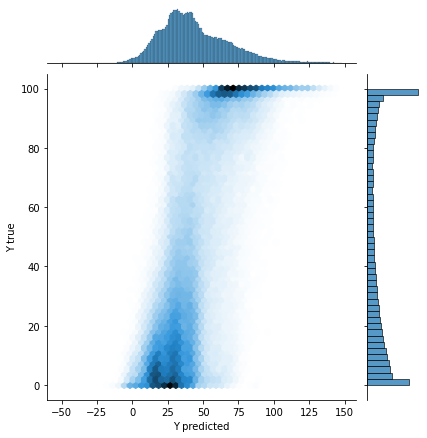

In [10]:
# Now we want to see how well our OLS regression performs in sample
# i.e. on the training data itself

# Make predictions for the same dataset X_all
Y_hat = regOls.predict(X_all)

# The mean squared error
mse_ols_sklearn  = mean_squared_error(Y_all,Y_hat)
print('\nMean squared error: ',mse_ols_sklearn)
# The coefficient of determination: 1 is perfect prediction
R2_ols_sklearn = r2_score(Y_all,Y_hat)
print('Coefficient of determination: ',R2_ols_sklearn)

# plot Y vs Y-hat
h = sns.jointplot(Y_hat, Y_all, kind="hex")
h.set_axis_labels('Y predicted', 'Y true');

Now we explore what consequences it has if a model overfits. For this we generate interaction and squared terms and compare model performance in a training and test set approach.

In [11]:
# Set a random number seed such that everybody has the same "random" split 
# of the data
np.random.seed(111)
# Split the data into train and test data using sklearn train_test_split object
#   (see: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

#   Note: This randomly split the data in 80% train and 20% test data
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size = 0.2)

In [12]:
# In order to better illustrate the overfitting effects we 
# artificially reduce the training data size.  Why do we do this? In general 
# a larger sample size helps to reduce overfitting problems. With a smaller 
# sample size polynomials of order 2 of our variables are sufficient to show 
# the effects. With the full sample size we would need to consider much higher 
# polynomials to show the same effects. 
N = 2000
X_train = X_train.iloc[:N,:]
Y_train = Y_train.iloc[:N]


In [13]:
# Use an sklearn function to generate polynomials of order 2 
# (square terms and interaction terms)
# (see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures.get_feature_names)
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
print('Total number of avaliable features',X_train_poly.shape[1])
lstFeatures = poly.get_feature_names()
# Show feature names
# list(lstFeatures)



Total number of avaliable features 91


In [14]:
# To explore overfitting we now run an small simulation...
# we squentially increase our model complexity by adding on additional features. 
# In each case we estimate the model and obtain models stats
# for the train and test set.

# Prepare a dataframe to hold the results
res = pd.DataFrame()

# Each iteration add in one  additional variables
for numVar in range(0,X_train_poly.shape[1]):

  # Define the feature set for the iteration 
  X_train_subSet = X_train_poly[:,:numVar+1]
  X_test_subSet = X_test_poly[:,:numVar+1]
  
  # Create linear regression object
  regOls = LinearRegression(normalize=True)

  # Train the model using the training sets
  regOls.fit(X_train_subSet, Y_train)

  # Get predicted values
  Y_hat_train = regOls.predict(X_train_subSet)
  Y_hat_test = regOls.predict(X_test_subSet)

  # Store model stats 
  res.loc[f"numVar_{numVar}",'Number of X Variables'] = X_train_subSet.shape[1]
  res.loc[f"numVar_{numVar}",'New Feature'] = lstFeatures[numVar]

  # The mean squared error
  res.loc[f"numVar_{numVar}",'MSE Train'] = mean_squared_error(Y_train,Y_hat_train)
  res.loc[f"numVar_{numVar}",'MSE Test'] = mean_squared_error(Y_test,Y_hat_test)
  # The coefficient of determination: 1 is perfect prediction
  res.loc[f"numVar_{numVar}",'R2 train'] = r2_score(Y_train,Y_hat_train)
  res.loc[f"numVar_{numVar}",'R2 test'] = r2_score(Y_test,Y_hat_test)


# => The column "New Feature" says which feature was added in this iteration 
#    on top of all the other added before, starting with only a constant
# => Have a look how R2 and MSE develops in the train and test set when 
#    increasing model complexity.
res


,Number of X Variables,New Feature,MSE Train,MSE Test,R2 train,R2 test
numVar_0,1.0,1,1216.525636,1213.005815,0.000000,-0.000181
numVar_1,2.0,x0,1092.857849,1102.641178,0.101657,0.090820
numVar_2,3.0,x1,1091.452623,1101.598429,0.102812,0.091680
numVar_3,4.0,x2,956.060772,981.976805,0.214106,0.190314
numVar_4,5.0,x3,913.715950,929.376214,0.248914,0.233685
...,...,...,...,...,...,...
numVar_86,87.0,x9 x10,530.718203,42927.052274,0.563743,-34.395385
numVar_87,88.0,x9 x11,523.025791,43000.110736,0.570066,-34.455625
numVar_88,89.0,x10^2,518.977085,37915.027224,0.573394,-30.262733
numVar_89,90.0,x10 x11,517.769904,37210.556117,0.574386,-29.681864


In [15]:
# Before we continue lets check if our simulation is correct, by comparing
# row "numVar_12" from "res" with our statsmodel and sklearn that we 
# have use above
print('Results from statsmodel:')
print('R2',olsStats_result.rsquared)
print('MSE',olsStats_result.mse_resid)

print('\nResults from sklearn:')
print('Mean squared error: ',mse_ols_sklearn)
print('Coefficient of determination: ',R2_ols_sklearn)

# Check that the results match our "res" data frame in row "numVar_12", which is
# a linear model with all explanatory variables
print('\nResults from row "numVar_12" from the "res" dataframe')
print(res.loc['numVar_12',:])

# => Note that in the simulation our X_train is a much smaller subsample 
#   of the full data set. Hence, we have some small variation but overall 
#   the result is very comparable 

Results from statsmodel:
R2 0.44772019128724705
MSE 669.1268671438286

Results from sklearn:
Mean squared error:  669.0920641940289
Coefficient of determination:  0.44772019128724727

Results from row "numVar_12" from the "res" dataframe
Number of X Variables          13
New Feature                   x11
MSE Train                 655.299
MSE Test                  672.795
R2 train                 0.461336
R2 test                  0.445248
Name: numVar_12, dtype: object


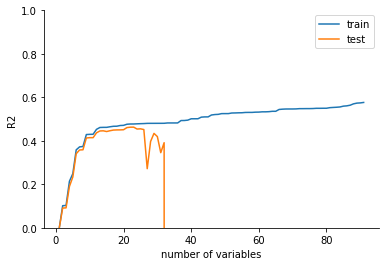

In [16]:
# Now back to our simulation results. To inspect the overfitting of the model
# lets plot R2 and MSE against the number of variables in the model.

# Start with R2
fig, ax = plt.subplots()
ax.plot(res['Number of X Variables'],res['R2 train'],label='train')
ax.plot(res['Number of X Variables'],res['R2 test'],label='test')
ax.set_ylabel('R2')
ax.set_xlabel('number of variables')
ax.set_ylim(0,1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend();

# => Note that in same cases our R2 in the test set is negative, which means
#    that our model is completely off...

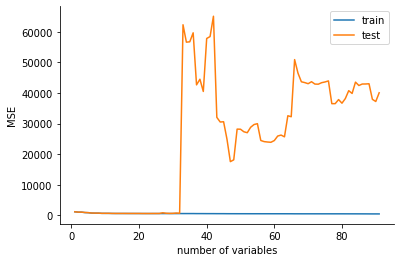

In [17]:
# ... and MSE
fig, ax = plt.subplots()
ax.plot(res['Number of X Variables'],res['MSE Train'],label='train')
ax.plot(res['Number of X Variables'],res['MSE Test'],label='test')
ax.set_ylabel('MSE')
ax.set_xlabel('number of variables')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend();

In [ ]:
# =====================================
# Question to discuss in the group:
# =====================================

# What can you conclude from the plots?

In [18]:
# Now, we can find the "best" specification from our simulation 
# by checking where R2 is highest in test set
iRes = res.loc[res['R2 test']==res['R2 test'].max(),:]
lstFeatures[:int(iRes['Number of X Variables'])]


['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x0 x6',
 'x0 x7',
 'x0 x8',
 'x0 x9']

In [ ]:
# =====================================
# Question to discuss in the group:
# =====================================

# Why might this model specification strategy not be ideal?

### Let's see how Lasso could be used here

In [ ]:
# The idea is that instead of adding in one variable at a time, we use all
# and let Lasso decide which ones to use. 

# It turns out that in order to get better results we need to make 
# the problem one step simpler for Lasso. If we use all polynomial terms 
# Lasso has convergence issues, at least with the restricted sample size 
# that we used above. Apparently the problem is that our variables are too 
# correlated. However, we can also illustrate the apporoach by using only linear 
# and square terms (excluding the interaction terms).  

In [19]:
# Get only the linear and square terms from the polynomials
idxSq = list(range(0,13))+[lstFeatures.index(c) for c in lstFeatures if '^2' in c]
lstColNames = [lstFeatures[i] for i in idxSq]
X_trainSq = X_train_poly[:,idxSq]
X_testSq = X_test_poly[:,idxSq]



In [20]:
# Get actual names for features instead of x1,...,x11
# this is required for a plot further down...
sCols = pd.Series(lstColNames)
sCols = sCols.replace({'\^2':'_sq'},regex=True)
sCols = sCols.replace({'1':'const'},regex=False)
dctReplace = {f"x{i}":lstX[i] for i in range(10,len(lstX))}
sCols = sCols.replace(dctReplace,regex=True)
dctReplace = {f"x{i}":lstX[i] for i in range(0,10)}
sCols = sCols.replace(dctReplace,regex=True)
lstColNames = sCols


In [21]:
# Create a list with alpha (= lambda in the lecture) values that we want to test for our Lasso estimation
lstAlpha = np.logspace(-16, -9, num = 10, base = 2)
lstAlpha

array([1.52587891e-05, 2.61610102e-05, 4.48527372e-05, 7.68994781e-05,
       1.31843230e-04, 2.26043631e-04, 3.87549085e-04, 6.64448242e-04,
       1.13918852e-03, 1.95312500e-03])

In [22]:
# Now loop over the alphas, run a Lasso estimation and get the model stats 
# Note the alphas here are just the same as the penalty (lambda)

# Create a dataframe to hold model stats
resLasso = pd.DataFrame()
# Create a dataframe to hold coef
resCoef = pd.DataFrame(columns=lstColNames)

# Loop over a range of alpha value
for alpha in lstAlpha:
  print(alpha)
  # Estimate Lasso
  if alpha >0:
    modLasso = Lasso(normalize=True, fit_intercept=True, alpha=alpha)
  else:  
    # in case of alpha = 0 use LinearRegression as recommended by sklearn
    modLasso = LinearRegression(normalize=True, fit_intercept=True)
  modLasso.fit(X_trainSq, Y_train)

  # Get predicted values
  Y_hat_train = modLasso.predict(X_trainSq)
  Y_hat_test = modLasso.predict(X_testSq)

  # Get model stats
  resLasso.loc[f"lasso_{alpha}",'MSE Train'] = mean_squared_error(Y_train,Y_hat_train)
  resLasso.loc[f"lasso_{alpha}",'MSE Test'] = mean_squared_error(Y_test,Y_hat_test)
  # The coefficient of determination: 1 is perfect prediction
  resLasso.loc[f"lasso_{alpha}",'R2 train'] = r2_score(Y_train,Y_hat_train)
  resLasso.loc[f"lasso_{alpha}",'R2 test'] = r2_score(Y_test,Y_hat_test)
  
  resLasso.loc[f"lasso_{alpha}",'alpha'] = alpha

  resCoef.loc[f'beta_hat_alpha{alpha}','alpha',] = alpha
  resCoef.loc[f'beta_hat_alpha{alpha}',lstColNames] = modLasso.coef_.transpose()


# => As you will see in the output, there are some values of alpha for which 
#   Lasso does not converge. This is not ideal but for our results we can 
#   ignore this for now.
# => Again check how MSE and R2 developed for varying values of alpha

resLasso

1.52587890625e-05
2.6161010218904826e-05


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204792.61671928136, tolerance: 243.3051272034694
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121472.55146182468, tolerance: 243.3051272034694
  positive)


4.485273719102779e-05
7.689947814299766e-05
0.00013184322984525218


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62065.61945965304, tolerance: 243.3051272034694
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27643.18648493581, tolerance: 243.3051272034694
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11016.104783599847, tolerance: 243.3051272034694
  positive)


0.00022604363092951433
0.000387549084953174


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4064.455622448586, tolerance: 243.3051272034694
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1452.1820482788607, tolerance: 243.3051272034694
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 684.3446799176745, tolerance: 243.3051272034694
  positive)


0.0006644482422726451
0.0011391885152110507
0.001953125


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264.6322461441159, tolerance: 243.3051272034694
  positive)


,MSE Train,MSE Test,R2 train,R2 test,alpha
lasso_1.52587890625e-05,593.657261,627.688094,0.512006,0.482441,0.000015
lasso_2.6161010218904826e-05,593.660229,627.619396,0.512004,0.482498,0.000026
lasso_4.485273719102779e-05,593.668860,627.505851,0.511996,0.482592,0.000045
lasso_7.689947814299766e-05,593.694066,627.323643,0.511976,0.482742,0.000077
lasso_0.00013184322984525218,593.767876,627.047868,0.511915,0.482969,0.000132
lasso_0.00022604363092951433,593.984358,626.682714,0.511737,0.483270,0.000226
lasso_0.000387549084953174,594.619874,626.373121,0.511215,0.483526,0.000388
lasso_0.0006644482422726451,595.720439,625.881953,0.510310,0.483931,0.000664
lasso_0.0011391885152110507,598.108087,625.772255,0.508347,0.484021,0.001139
lasso_0.001953125,604.935875,629.384882,0.502735,0.481042,0.001953


In [23]:
# Get the "best" alpha by checking where MSE is lowest in test set 
# (or R2 is highest)
iRes = resLasso.loc[resLasso['R2 test']==resLasso['R2 test'].max(),:]
alphaBest = resLasso.loc[resLasso['R2 test']==resLasso['R2 test'].max(),'alpha'][0]
print('The "best" (from those we tried in the simulations) is: ', alphaBest)

The "best" (from those we tried in the simulations) is:  0.0011391885152110507


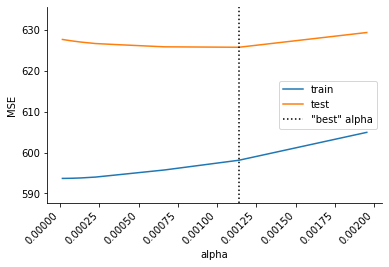

In [24]:
# Plot result

# Define range of Y that should be shown in plot
rangeYLow = resLasso['MSE Train'].min()*0.99
rangeYHigh = resLasso['MSE Test'].max()*1.01

fig, ax = plt.subplots()
ax.plot(resLasso['alpha'],resLasso['MSE Train'],label='train')
ax.plot(resLasso['alpha'],resLasso['MSE Test'],label='test')
ax.plot([alphaBest,alphaBest],[rangeYLow,rangeYHigh],label='"best" alpha',linestyle=':',color='black')
ax.set_ylabel('MSE')
ax.set_xlabel('alpha')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.autofmt_xdate(rotation=45)
ax.set_ylim(rangeYLow,rangeYHigh)
ax.legend();

In [25]:
# Repeat the simulation with a slightly larger alpha range
# in order to prepare a plot with the estimated coefficients against alpha 
# Df to hold coef
resCoef = pd.DataFrame(columns=lstColNames)

# Loop over a range of alpha value
for alpha in np.logspace(-16, 0, num = 10, base = 2):
  # Estimate Lasso
  if alpha >0:
    modLasso = Lasso(normalize=True, fit_intercept=True, alpha=alpha)
  else:  
    # in case of alpha = 0 use LinearRegression as recommended by sklearn
    modLasso = LinearRegression(normalize=True, fit_intercept=True)
  modLasso.fit(X_trainSq, Y_train)

  resCoef.loc[f'beta_hat_alpha{alpha}','alpha',] = alpha
  resCoef.loc[f'beta_hat_alpha{alpha}',lstColNames] = modLasso.coef_.transpose()


import plotly.graph_objects as go
# Create traces
fig = go.Figure()

for strBeta in resCoef.columns[1:]:
  # ax.plot(resCoef['alpha'],resPlot[strBeta],label=strBeta)
  fig.add_trace(go.Scatter(x=resCoef['alpha'], y=resCoef[strBeta],
                      mode='lines',
                      name=strBeta))

rangeYLow = resCoef.min().min()*0.99
rangeYHigh = resCoef.max().max()*1.01
fig.add_trace(go.Scatter(x=[alphaBest,alphaBest], y=[rangeYLow,rangeYHigh],
                    mode='lines',
                    name='bestAlpha',line=dict(color='black', dash='dash')))

fig.update_layout(
    width=800,
    height=400,
    xaxis_type="log",
    xaxis = dict(
       autorange='reversed'
    ),
    yaxis = dict(
       range=[rangeYLow,rangeYHigh],
    )
)
fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204792.61671928136, tolerance: 243.3051272034694
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49909.75446997769, tolerance: 243.3051272034694
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6276.286142324097, tolerance: 243.3051272034694
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 776.0249039

# Day 1 Lab

Today's lab will have you run an OLS and LASSO regression using the deforestation data you saw in the introduction slides and in todays lecture (see code above). 

In the above specification we work with a rather restricted, preselected set of explnatory variables. Also we restricted the sample size artifically. Now try to run a model with a larger set of explanatory variables and using the full data set.

In [26]:
# If you haven't already, load the deforestation data following the code above.
# ==============
# Your code here
# ==============


In [27]:
# Define target (dependent) variable (% forest cover for 2018)
strY = 'perc_treecover'

# Define a list of features names (explantory variables)
lstX = [
  'bean',
 'carrot',
 'cassava',
 'chickpea',
 'citrus',
 'coffee',
 'groundnut',
 'maize',
 'soy',
 'sugarcane',
 'tomato',
 'wheat',
 'perm_water',
 'travel_min',
 'defor_2001',
 'defor_2002',
 'defor_2003',
 'defor_2004',
 'defor_2005',
 'defor_2006',
 'defor_2007',
 'defor_2008',
 'defor_2009',
 'defor_2010',
 'defor_2011',
 'defor_2012',
 'defor_2013',
 'defor_2014',
 'defor_2015',
 'defor_2016',
 'defor_2017',
 'defor_2018',
 'wdpa_1990',
 'wdpa_1991',
 'wdpa_1993',
 'wdpa_1994',
 'wdpa_1995',
 'wdpa_1996',
 'wdpa_1997',
 'wdpa_1998',
 'wdpa_1999',
 'wdpa_2000',
 'wdpa_2001',
 'wdpa_2002',
 'wdpa_2003',
 'wdpa_2004',
 'wdpa_2005',
 'wdpa_2006',
 'wdpa_2007',
 'wdpa_2008',
 'wdpa_2009',
 'wdpa_2010',
 'wdpa_2011',
 'wdpa_2012',
 'wdpa_2014',
 'wdpa_2015',
 'wdpa_2017',
 'wdpa_2018',
 'chirps_2001',
 'chirps_2002',
 'chirps_2003',
 'chirps_2004',
 'chirps_2005',
 'chirps_2006',
 'chirps_2007',
 'chirps_2008',
 'chirps_2009',
 'chirps_2010',
 'chirps_2011',
 'chirps_2012',
 'chirps_2013',
 'chirps_2014',
 'chirps_2015',
 'chirps_2016',
 'chirps_2017',
 'chirps_2018',
 'population_2000',
 'population_2005',
 'population_2010',
 'population_2015',
 'cropland',
 'pasture',
 'mean_elev',
 'sd_elev',
 'near_road',
 'bean_lag_1st_order',
 'carrot_lag_1st_order',
 'cassava_lag_1st_order',
 'chickpea_lag_1st_order',
 'citrus_lag_1st_order',
 'coffee_lag_1st_order',
 'groundnut_lag_1st_order',
 'maize_lag_1st_order',
 'soy_lag_1st_order',
 'sugarcane_lag_1st_order',
 'tomato_lag_1st_order',
 'wheat_lag_1st_order',
 'perm_water_lag_1st_order',
 'travel_min_lag_1st_order',
 'defor_2001_lag_1st_order',
 'defor_2002_lag_1st_order',
 'defor_2003_lag_1st_order',
 'defor_2004_lag_1st_order',
 'defor_2005_lag_1st_order',
 'defor_2006_lag_1st_order',
 'defor_2007_lag_1st_order',
 'defor_2008_lag_1st_order',
 'defor_2009_lag_1st_order',
 'defor_2010_lag_1st_order',
 'defor_2011_lag_1st_order',
 'defor_2012_lag_1st_order',
 'defor_2013_lag_1st_order',
 'defor_2014_lag_1st_order',
 'defor_2015_lag_1st_order',
 'defor_2016_lag_1st_order',
 'defor_2017_lag_1st_order',
 'defor_2018_lag_1st_order',
 'wdpa_1990_lag_1st_order',
 'wdpa_1991_lag_1st_order',
 'wdpa_1993_lag_1st_order',
 'wdpa_1994_lag_1st_order',
 'wdpa_1995_lag_1st_order',
 'wdpa_1996_lag_1st_order',
 'wdpa_1997_lag_1st_order',
 'wdpa_1998_lag_1st_order',
 'wdpa_1999_lag_1st_order',
 'wdpa_2000_lag_1st_order',
 'wdpa_2001_lag_1st_order',
 'wdpa_2002_lag_1st_order',
 'wdpa_2003_lag_1st_order',
 'wdpa_2004_lag_1st_order',
 'wdpa_2005_lag_1st_order',
 'wdpa_2006_lag_1st_order',
 'wdpa_2007_lag_1st_order',
 'wdpa_2008_lag_1st_order',
 'wdpa_2009_lag_1st_order',
 'wdpa_2010_lag_1st_order',
 'wdpa_2011_lag_1st_order',
 'wdpa_2012_lag_1st_order',
 'wdpa_2014_lag_1st_order',
 'wdpa_2015_lag_1st_order',
 'wdpa_2017_lag_1st_order',
 'wdpa_2018_lag_1st_order',
 'chirps_2001_lag_1st_order',
 'chirps_2002_lag_1st_order',
 'chirps_2003_lag_1st_order',
 'chirps_2004_lag_1st_order',
 'chirps_2005_lag_1st_order',
 'chirps_2006_lag_1st_order',
 'chirps_2007_lag_1st_order',
 'chirps_2008_lag_1st_order',
 'chirps_2009_lag_1st_order',
 'chirps_2010_lag_1st_order',
 'chirps_2011_lag_1st_order',
 'chirps_2012_lag_1st_order',
 'chirps_2013_lag_1st_order',
 'chirps_2014_lag_1st_order',
 'chirps_2015_lag_1st_order',
 'chirps_2016_lag_1st_order',
 'chirps_2017_lag_1st_order',
 'chirps_2018_lag_1st_order',
 'population_2000_lag_1st_order',
 'population_2005_lag_1st_order',
 'population_2010_lag_1st_order',
 'population_2015_lag_1st_order',
 'cropland_lag_1st_order',
 'pasture_lag_1st_order',
 'mean_elev_lag_1st_order',
 'sd_elev_lag_1st_order',
 'near_road_lag_1st_order',
 ]

# Get target variable and features
Y_all = df[strY]
X_all = df.loc[:,lstX]


In [ ]:
# split the data into a train and test set as above
# ==============
# Your code here
# ==============

In [ ]:
# Run an OLS model to predict percent forest cover (using the 'train' part of the previous split for the training)
# ==============
# Your code here
# ==============

In [ ]:
# Generate the predicted values for forest cover in the train and test set
# ==============
# Your code here
# ==============

In [ ]:
# Produce measures of model fit (R2 and MSE) for train and test data
# ==============
# Your code here
# ==============

In [ ]:
# plot predicted versus actual forest cover for test set
# ==============
# Your code here
# ==============

Now run the same specification using a LASSO

In [ ]:
# generate a LASSO function from sklearn
# ==============
# Your code here
# ==============
modLasso = ...

In [ ]:
# Use the same variable specification as for you OLS model and fit it 
# to the training data
# ==============
# Your code here
# ==============


In [ ]:
# Create fitted values for train and test set and compare model fit (R2/MSE)
# as you have done it for OLS
# ==============
# Your code here
# ==============

In [ ]:
# Check how many coefficients are selected in Lasso (i.e. are greater 0)
print('Number of total coefficients in Lasso: ' , modLasso.coef_.shape[0])
print('Number of selected coefficients in Lasso: ' ,np.sum(modLasso.coef_>0))

print('\nList selected variables:\n')
list(pd.Series(lstX).loc[modLasso.coef_>0])

Now change your alpha (lambda) and repeat.  

What happens as you increase your alpha? As you decrease your alpha? Are the results more or less similar to your OLS results?

Note: In this specific case it might be quite difficult to beat the simple OLS result in terms of MSE/R2 in the test set, because OLS is not really overfitting in this example.   

(Optional) So far we are just choosing our training and test set randomly.  Is this valid if there is high spatial correlation?  (if you like) try splitting your data based on latitude and re-run the OLS and the LASSO.  Do you expect your results to be better or worse than using the random split?

In [ ]:
# set a cut-point in the latitude variable to split data into a train and test set

In [ ]:
# re-run OLS and LASSO models using this new train and test set
